**In this Notebook we will use a Tagged Twitter CSV file to train and save a RNN in order to use it in our covid-vaccine dataset for our sentiment analysis**

# Importing Libraries

In [2]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Load Dataset

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/file/d/1Auz_mQrYW9YEpdQflVHpCGW1BZAs6VYO/view?usp=sharing' #the shareable link


In [5]:
 id = '1Auz_mQrYW9YEpdQflVHpCGW1BZAs6VYO'

print (id) # Verify that you have everything after '='

1Auz_mQrYW9YEpdQflVHpCGW1BZAs6VYO


In [36]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training.1600000.processed.noemoticon.csv')  
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

In [37]:
data = data.sample(frac=1)
data = data[:200000]

# Data Visualization 

Dataset details target: the polarity of the tweet (0 = negative, 4 = positive)

In [38]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 6)


In [39]:
data

polarity  ...                                               text
1079898         4  ...                            for a moment like this 
686840          0  ...  I'm glad I'm home safely, what a fucked up nig...
788805          0  ...  My new place in paddo is so much quieter. It's...
628723          0  ...  @LilLadyV08 I was n a car accident last week. ...
1091145         4  ...  I had a really good day today. Got my vinyls, ...
...           ...  ...                                                ...
711022          0  ...  @ddlovato awh demi rest your voice as much as ...
396309          0  ...  @Madmonaghan i work weekends  sooooo shit! i h...
486574          0  ...  @PumpsAndGloss Girl, U and me both!! I can't w...
181403          0  ...  @brookeburke Good for you, have a glass of red...
602620          0  ...  @maryk3lly the weather is bad&lt;--- &quot;yea...

[200000 rows x 6 columns]

In [40]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

polarity  ...                                               text
1079898         1  ...                            for a moment like this 
686840          0  ...  I'm glad I'm home safely, what a fucked up nig...
788805          0  ...  My new place in paddo is so much quieter. It's...
628723          0  ...  @LilLadyV08 I was n a car accident last week. ...
1091145         1  ...  I had a really good day today. Got my vinyls, ...

[5 rows x 6 columns]

In [41]:
#Some metric statistics of our dataset
data.describe()

polarity            id
count  200000.000000  2.000000e+05
mean        0.498335  1.999241e+09
std         0.499998  1.933027e+08
min         0.000000  1.467811e+09
25%         0.000000  1.956990e+09
50%         0.000000  2.002116e+09
75%         1.000000  2.177155e+09
max         1.000000  2.329206e+09

In [42]:

# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))



Total length of the data is:         200000
No. of positve tagged sentences is:  99667
No. of negative tagged sentences is: 100333


# Data Proccessing

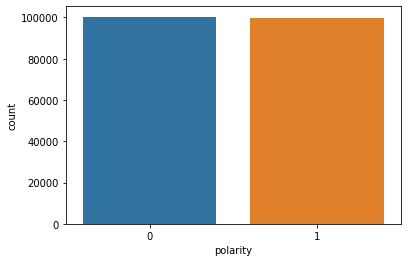

In [43]:
%matplotlib inline
sns.countplot(data['polarity'])

In [44]:

# Removing the unnecessary columns.
data.drop(['date','query','user'], axis=1, inplace=True)


In [45]:
data.drop('id', axis=1, inplace=True)


In [46]:
data.head()

polarity                                               text
1079898         1                            for a moment like this 
686840          0  I'm glad I'm home safely, what a fucked up nig...
788805          0  My new place in paddo is so much quieter. It's...
628723          0  @LilLadyV08 I was n a car accident last week. ...
1091145         1  I had a really good day today. Got my vinyls, ...

In [48]:

#converting pandas object to a string type
data['text'] = data['text'].astype('str')



In [49]:
#load stopwords
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
exclude_words = set(("hasn", "couldn", "weren", "wasn", "not", "doesn", "shouldn", "isn","didn", "haven", "aren", "needn", "nor", "aren't", "mightn't", "hasn't","wasn't", "couldn't","wouldn","won't","doesn't","don't","didn't","mightn","isn't")) 
stopword = stop_word.difference(exclude_words)

print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'and', 'did', 'y', 'some', 'down', 'won', 'few', "she's", "should've", 'she', 'i', "mustn't", 'into', 'itself', 'don', 'the', 'with', 'both', 'no', 'had', 'we', 'after', 'where', 'when', 'all', "shouldn't", 'these', 'too', 'll', 'of', 'herself', 'are', 'as', 'there', 'but', 'was', 'themselves', 'his', 'in', 'own', 'such', 'off', 'hers', "it's", 'myself', 'doing', 'ours', 'your', 'until', 'have', 'whom', 'be', "wouldn't", 'on', 'at', 'up', 'while', 'same', 'to', 'me', 'here', 'himself', 'should', 'a', 'each', 'were', 'they', 'this', 'ourselves', "you'll", 'been', 'why', 'hadn', 'for', 'mustn', 'again', 'will', 'them', 'ain', 'theirs', 're', 'or', 'can', 'yourselves', 'over', 'by', 'those', 'under', 'their', 'which', 'during', "hadn't", 'further', 'above', 'shan', 'you', 'him', 'most', 'then', 'what', 'through', 'from', 'who', 'do', "haven't", 'ma', 'yours', 'once', 've

In [50]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Now some textcleaning Preproccessing**

In [51]:

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtag = '#[^\s]+'
amp = 'amp[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
  
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    # Remove hashtag #
    tweet = re.sub(hashtag,'',tweet)
    #Remove amp.
    tweet = re.sub(amp,'',tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

def demoji(text):
	emoji_pattern = re.compile("["
		u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
	                           "]+", flags=re.UNICODE)
	return(emoji_pattern.sub(r'', text))

#def shortword(text):
       # shortword = re.compile(r'\W*\b\w{1,2}\b')
        #return(shortword.sub(r'', text))



In [53]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
#data['processed_tweets'] = data['processed_tweets'].astype(str)
data['processed_tweets'] = data['processed_tweets'].apply(lambda x:demoji(x))
#df3['processed_tweets'] = df3['processed_tweets'].astype(str)
#data['processed_tweets'] = data['processed_tweets'].apply(lambda x:shortword(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [57]:
data.head(50)

polarity  ...                                   processed_tweets
1079898         1  ...                                        moment like
686840          0  ...  im glad im home safely fucked night good bad m...
788805          0  ...  new place paddo much quieter wanted sudden im ...
628723          0  ...  car accident last week keep gttn spasm pinched...
1091145         1  ...  really good day today got vinyl saw movie chil...
1302982         1  ...  ahh aching back stupid bed tkn dog doggy day c...
342275          0  ...  whore keep talking shit meand cant nothing cuz...
1297901         1  ...                     oh gosh hope not lol sure fine
1252202         1  ...  not sure got going week going jam session tomo...
1281107         1  ...                       happy birthday shaun fun atl
1138511         1  ...                     long day not even close ending
1509400         1  ...                   sad magic lose cheer next season
753225          0  ...                             somebody isnt im sorry
1146027         1  ...                                 hey paula go peter
109804          0  ...  swear still smell smoke hair ahh hate bon fire...
1344680         1  ...  im helping friend advertise place havent got c...
1108139         1  ...  bye yall going get drunk love day like beautif...
1584746         1  ...                           prob not going bed today
1508564         1  ...    sry clarify im pushing selective tweet facebook
263998          0  ...  fuck sucked want new moon ok ok alittle funny ...
31106           0  ...                      im sorry hope get better soon
1112649         1  ...  best possible thing today japanese client brou...
85896           0  ...  hi tom miss spoke portuguese google translate ...
362593          0  ...                        im still journeyman alchemy
488599          0  ...  im excited tom wont game def watching wgn len ...
497485          0  ...                            thanks vomit scene nice
1052391         1  ...             haha im sleepin soon get home awh suck
1304206         1  ...                house sitting open heated pool time
1128956         1  ...                 gnight wee king gig tomorrow night
47766           0  ...                    shame didnt get meet sorry busy
920354          1  ...  bye ilove quotmileycyrus demilovatoquot best s...
893214          1  ...  ya ya evlo teckinika time waste panranga kind ...
126534          0  ...                                dont want go school
67169           0  ...  cant believe send shoe back nike tear swoosh t...
1041177         1  ...                      loooooovely day today morning
358174          0  ...  laying relaxing driving back back sunday anoth...
1114510         1  ...                                  absofuckinglutely
585777          0  ...                            im losing twitter buddy
951575          1  ...      oh btw im not sure stereo lol whatever called
143466          0  ...  envious terminator slurpee something well neve...
949266          1  ...  payback mother fucking bitch keeep lying wiiit...
1315435         1  ...  well ill help brother blog well done way keep ...
973582          1  ...                                      taken picture
586979          0  ...  good question guess different generation sadly...
1509446         1  ...  okay well im not egotistical id settle one wom...
335636          0  ...                         load battery lol suck hard
188120          0  ...                            lily bit boob made mark
1423180         1  ...                         daughter fine virus thanks
209275          0  ...  even though movie look like would scare crap w...
1016302         1  ...          one word drescibes picture frothhhh xoxox

[50 rows x 3 columns]

# Vectorization and Splitting Data

In [58]:

X = data['processed_tweets'].values
y = data['polarity'].values



In [59]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


**Convert text to word frequency vectors**

In [60]:

#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))



Vector fitted.
No. of feature_words:  98961


In [61]:
print(X.shape)
print(y.shape)

(200000, 98961)
(200000,)


**Split and Train Test**



The Preprocessed Data is divided into 2 sets of data:


*   Training Data: The dataset upon which the model would be trained on. Contains 80% data.
*  Test Data: The dataset upon which the model would be tested against. Contains 20% data.








In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [63]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 98961)
y_train (160000,)

X_test (40000, 98961)
y_test (40000,)


In [64]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Accuracy of model on training data : 82.1925
Accuracy of model on testing data : 77.6375 

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     20081
           1       0.76      0.80      0.78     19919

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



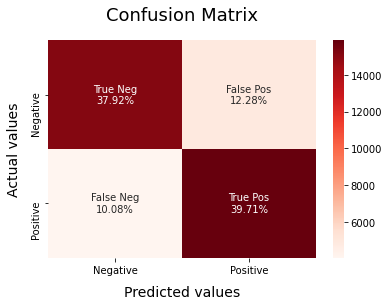

In [65]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

# RNN

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
import keras

In [67]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    0  484    6]
 [   0    0    0 ...  532  137   64]
 [   0    0    0 ...  248  303  145]
 ...
 [   0    0    0 ...  302    1  108]
 [   0    0    0 ...   27 1541  458]
 [   0    0    0 ...  184 1582   80]]


In [68]:

X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)


In [69]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(Bidirectional(layers.LSTM(64,dropout=0.5)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
5000/5000 [==============================] - 1026s 205ms/step - loss: 0.5312 - accuracy: 0.7243 - val_loss: 0.4684 - val_accuracy: 0.7785

Epoch 00001: val_accuracy improved from -inf to 0.77847, saving model to rnn_model.hdf5
Epoch 2/5
5000/5000 [==============================] - 1008s 202ms/step - loss: 0.4518 - accuracy: 0.7850 - val_loss: 0.4610 - val_accuracy: 0.7821

Epoch 00002: val_accuracy improved from 0.77847 to 0.78205, saving model to rnn_model.hdf5
Epoch 3/5
5000/5000 [==============================] - 1019s 204ms/step - loss: 0.4320 - accuracy: 0.7954 - val_loss: 0.4639 - val_accuracy: 0.7832

Epoch 00003: val_accuracy improved from 0.78205 to 0.78325, saving model to rnn_model.hdf5
Epoch 4/5
5000/5000 [==============================] - 994s 199ms/step - loss: 0.4173 - accuracy: 0.8038 - val_loss: 0.4646 - val_accuracy: 0.7798

Epoch 00004: val_accuracy did not improve from 0.78325
Epoch 5/5
5000/5000 [==============================] - 1014s 203ms/step - loss: 

In [70]:
sequence = tokenizer.texts_to_sequences(["I am  healthy"])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

print(pred)

Positive
[[0.8413259]]


In [71]:
model = tf.keras.models.load_model('rnn_model.hdf5')


In [72]:
sequence = tokenizer.texts_to_sequences(["I like the vaccines but i do not trust the companies"])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

print(pred)

Negative
[[0.13808885]]


In [73]:
!mkdir -p saved_model
model.save('saved_model/biderectional_model.hdf5') 

In [ ]:
!ls saved_model

biderectional_model.hdf5


# Loading our covid vaccine dataset

In [74]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [75]:
link1 = 'https://drive.google.com/file/d/102uB9cfp5ul3bc9WZZJ-A8MbsP1HAySy/view?usp=sharing' #the shareable link

In [76]:
id = '102uB9cfp5ul3bc9WZZJ-A8MbsP1HAySy'

print (id) # Verify that you have everything after '='

102uB9cfp5ul3bc9WZZJ-A8MbsP1HAySy


In [77]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tweets_loc.csv')  
df3 = pd.read_csv('tweets_loc.csv')


In [80]:
df3

Unnamed: 0            id  ...        long        lat
0               1  1.340539e+18  ... -118.231705  34.219170
1               2  1.338159e+18  ... -122.727652  37.785063
2               3  1.337858e+18  ...   -2.942752  42.685166
3               4  1.337856e+18  ... -123.124101  49.257308
4               5  1.337854e+18  ...   12.502155  13.187038
...           ...           ...  ...         ...        ...
69718       69719  1.382248e+18  ...    6.143047  46.204829
69719       69720  1.382246e+18  ...   28.855412 -27.228607
69720       69721  1.382245e+18  ...   12.502155  13.187038
69721       69722  1.382243e+18  ...    0.126595  52.197586
69722       69723  1.382243e+18  ...   72.977545  19.232121

[69723 rows x 22 columns]


**Pre-processing text data**

Most of the text data are cleaned by following below steps.
*   *Remove punctuations*
*   *Tokenization - Converting a sentence into list of words* 
*   *Remove stopwords* 
*   *Lammetization/stemming - Tranforming any form of a word to its root word*





  

  




# Pre-Proccess for our prediction Model

In [81]:
#converting pandas object to a string type
df3['text'] = df3['text'].astype('str')

In [82]:
nltk.download('punkt')
nltk.download('wordnet')
stop_word = set(stopwords.words('english'))
exclude_words = set(("hasn", "couldn", "weren", "wasn", "not", "doesn", "shouldn", "isn","didn", "haven", "aren", "needn", "nor", "")) 
stopword = stop_word.difference(exclude_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtag = '#[^\s]+'
amp = 'amp[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove hashtags
    tweet = re.sub(hashtag,'', tweet)
    #Remove amp
    tweet = re.sub(amp,'',tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

def demoji(text):
	emoji_pattern = re.compile("["
		u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
	                           "]+", flags=re.UNICODE)
	return(emoji_pattern.sub(r'', text))

#def shortword(text):
        #shortword = re.compile(r'\W*\b\w{1,2}\b')
        #return(shortword.sub(r'', text))

In [84]:
df3['processed_tweets'] = df3['text'].apply(lambda x: process_tweets(x))
#df3['processed_tweets'] = df3['processed_tweets'].astype(str)
df3['processed_tweets'] = df3['processed_tweets'].apply(lambda x:demoji(x))

#df3['processed_tweets'] = df3['processed_tweets'].astype(str)
#df3['processed_tweets'] = df3['processed_tweets'].apply(lambda x:shortword(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [85]:
df3.head(10)

Unnamed: 0            id  ...        long        lat
0           1  1.340539e+18  ... -118.231705  34.219170
1           2  1.338159e+18  ... -122.727652  37.785063
2           3  1.337858e+18  ...   -2.942752  42.685166
3           4  1.337856e+18  ... -123.124101  49.257308
4           5  1.337854e+18  ...   12.502155  13.187038
5           6  1.337853e+18  ...   -1.881253  52.494879
6           7  1.337851e+18  ...         NaN        NaN
7           8  1.337851e+18  ...   12.502155  13.187038
8           9  1.337850e+18  ...   12.502155  13.187038
9          10  1.337842e+18  ...   73.065151  33.693812

[10 rows x 22 columns]

# Perform Sentiment Analysis

In [86]:
#converting pandas object to a string type
df3['processed_tweets'] = df3['processed_tweets'].astype('str')

In [87]:
#Calculate the Polarities of our tweets
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(df3['processed_tweets'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)

pred



array([[0.77360326],
       [0.3273529 ],
       [0.79242563],
       ...,
       [0.9790274 ],
       [0.6483894 ],
       [0.9517286 ]], dtype=float32)

In [88]:
pred.shape

(69723, 1)

In [89]:
df3['Polarity'] = pred
df3

Unnamed: 0            id  ...        long        lat
0               1  1.340539e+18  ... -118.231705  34.219170
1               2  1.338159e+18  ... -122.727652  37.785063
2               3  1.337858e+18  ...   -2.942752  42.685166
3               4  1.337856e+18  ... -123.124101  49.257308
4               5  1.337854e+18  ...   12.502155  13.187038
...           ...           ...  ...         ...        ...
69718       69719  1.382248e+18  ...    6.143047  46.204829
69719       69720  1.382246e+18  ...   28.855412 -27.228607
69720       69721  1.382245e+18  ...   12.502155  13.187038
69721       69722  1.382243e+18  ...    0.126595  52.197586
69722       69723  1.382243e+18  ...   72.977545  19.232121

[69723 rows x 22 columns]

In [91]:
df3.drop(['Unnamed: 0','id'], axis=1, inplace=True)

In [ ]:
#creat a function to compute the negative and positive analysis
def getAnalysis(score):
  if score < 0.5:
    return "Negative"
  else:
    return "Positive"

df3['Analysis']=df3['Polarity'].apply(getAnalysis)



In [92]:
df3

user_name  ...        lat
0                                            Rachel Roh  ...  34.219170
1                                           Albert Fong  ...  37.785063
2                                              eli🇱🇹🇪🇺👌  ...  42.685166
3                                         Charles Adler  ...  49.257308
4                                  Citizen News Channel  ...  13.187038
...                                                 ...  ...        ...
69718                         Russian Mission in Geneva  ...  46.204829
69719                                       Mora Mosese  ... -27.228607
69720                                    Robert ka Boss  ...  13.187038
69721                                        Mick Brown  ...  52.197586
69722  #गांधीदूत Azaz Shaikh ऐजाज़ शेख اعجاز شیخ #WithRG  ...  19.232121

[69723 rows x 20 columns]

In [93]:
#Save the csv file for use in different notebooks
df3.to_csv(r'covid_vaccine_tagged_bi.csv',index = False, header= True)

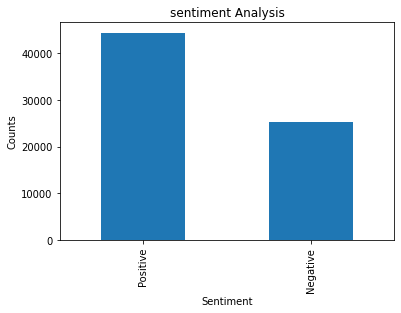

In [94]:
#Check the Value counts of Positive Negative Tweets
df3['Analysis'].value_counts()

plt.title("sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
df3['Analysis'].value_counts().plot(kind='bar')
plt.show()





# Data Visualization

In [95]:
#Create instances of positive and negative dataframes
df_positive = df3.loc[df3['Analysis'] == 'Positive']
df_negative = df3.loc[df3['Analysis'] == 'Negative']

In [96]:
#converting pandas object to a string type
df3['processed_tweets'] = df3['processed_tweets'].astype('str')

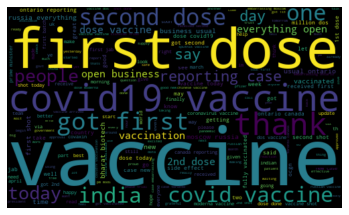

In [97]:
#Plot the Word Cloud For Positive Tweets
allWords = ' '.join( [twts for twts in df_positive['processed_tweets']])
wordCloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 119).generate(allWords)

plt.imshow(wordCloud, interpolation=  "bilinear")
plt.axis('off')
plt.show()

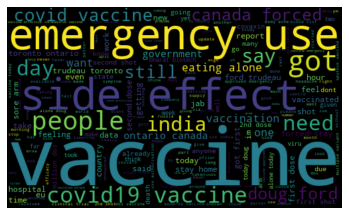

In [98]:
#Plot the Word Cloud For Negative Tweets
allWords = ' '.join( [twts for twts in df_negative['processed_tweets']])
wordCloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 119).generate(allWords)

plt.imshow(wordCloud, interpolation=  "bilinear")
plt.axis('off')
plt.show()

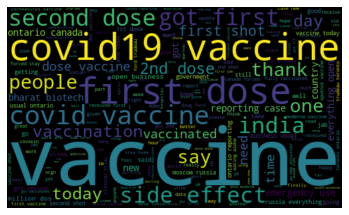

In [99]:
#Plot the Word Cloud For All tweets Tweets
allWords = ' '.join( [twts for twts in df3['processed_tweets']])
wordCloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 119).generate(allWords)

plt.imshow(wordCloud, interpolation=  "bilinear")
plt.axis('off')
plt.show()

   Analysis  tweets
0  Negative   24869
1  Positive   44845


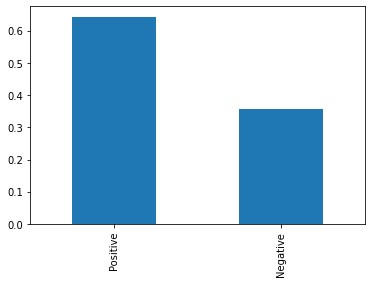

In [ ]:
# Plot sentiment value counts
import plotly.express as px
import matplotlib.pyplot as plt
df3['Analysis'].value_counts(normalize=True).plot.bar();

timeline = df3.groupby(['Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='Analysis', y="tweets", color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

In [ ]:
# Convert dates
df3['date'] = pd.to_datetime(df3['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = df3.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA"], category_orders={'sentiment': ['negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    #df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='Analysis',  color_discrete_sequence=["#636EFA","#EF553B" ], category_orders={'Analysis': ['negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(df3, ['covaxin'], title='Covaxin')
sinovac = filtered_timeline(df3, ['sinovac'], title='Sinovac')
sinopharm = filtered_timeline(df3, ['sinopharm'], title='Sinopharm')
moderna = filtered_timeline(df3, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(df3, ['sputnik'], title='Sputnik V')
oxford = filtered_timeline(df3, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')
pfizer = filtered_timeline(df3, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sputnik V': sputnikv, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['Analysis'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative','Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

# Spike Detection


In [ ]:
#converting pandas object to a string type
df3['text'] = df3['text'].astype('str')

In [ ]:
spike_data = df3

#converting pandas object to a string type
spike_data['user_favourites'] = spike_data['user_favourites'].astype('int')
spike_data['user_followers'] = spike_data['user_followers'].astype('int')
spike_data['user_friends'] = spike_data['user_friends'].astype('int')

#spike_data = spike_data.loc[(spike_data['user_favourites'] > 10000) & (spike_data['user_followers'] > 10000)]

In [ ]:
spike_data

id  ...  Analysis
0      1340539111971516416  ...  Positive
1      1338158543359250433  ...  Negative
2      1337858199140118533  ...  Positive
3      1337855739918835717  ...  Negative
4      1337854064604966912  ...  Positive
...                    ...  ...       ...
69709  1382248484259123205  ...  Negative
69710  1382246393532801026  ...  Positive
69711  1382245076303179778  ...  Positive
69712  1382243373747146752  ...  Positive
69713  1382243035073810434  ...  Positive

[69714 rows x 19 columns]

   Analysis  tweets
0  Negative   26298
1  Positive   43416


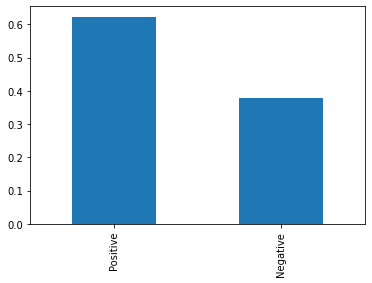

In [ ]:
# Plot sentiment value counts
import plotly.express as px
import matplotlib.pyplot as plt
spike_data['Analysis'].value_counts(normalize=True).plot.bar();

timeline = spike_data.groupby(['Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='Analysis', y="tweets", color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

In [ ]:
# Convert dates
spike_data['date'] = pd.to_datetime(spike_data['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = spike_data.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA"], category_orders={'Analysis': ['Negative', 'Positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [ ]:
# Function to filter the data to a single date and print tweets from users with the most followers
spike_data_date = spike_data
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'processed_tweets','user_location','Analysis']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(spike_data, ['2021-03-01', '2021-03-03','2021-04-08','2021-04-21'])

date  ...  Analysis
15399  2021-03-01  ...  Negative
16806  2021-03-01  ...  Negative
17994  2021-03-01  ...  Negative
17995  2021-03-01  ...  Negative
16914  2021-03-01  ...  Negative
18936  2021-03-01  ...  Positive
17463  2021-03-01  ...  Positive
16779  2021-03-01  ...  Negative
16818  2021-03-01  ...  Positive
17990  2021-03-01  ...  Negative

[10 rows x 4 columns]

date  ...  Analysis
20775  2021-03-03  ...  Negative
20779  2021-03-03  ...  Positive
20791  2021-03-03  ...  Negative
20388  2021-03-03  ...  Negative
20399  2021-03-03  ...  Positive
20403  2021-03-03  ...  Positive
19112  2021-03-03  ...  Positive
19152  2021-03-03  ...  Positive
19911  2021-03-03  ...  Negative
20695  2021-03-03  ...  Negative

[10 rows x 4 columns]

date  ...  Analysis
51374  2021-04-08  ...  Positive
51382  2021-04-08  ...  Positive
51389  2021-04-08  ...  Positive
51381  2021-04-08  ...  Positive
51178  2021-04-08  ...  Negative
51398  2021-04-08  ...  Positive
55328  2021-04-08  ...  Positive
55089  2021-04-08  ...  Positive
54989  2021-04-08  ...  Positive
56205  2021-04-08  ...  Negative

[10 rows x 4 columns]

date  ...  Analysis
66504  2021-04-21  ...  Negative
65482  2021-04-21  ...  Negative
61318  2021-04-21  ...  Positive
66205  2021-04-21  ...  Positive
61506  2021-04-21  ...  Negative
66243  2021-04-21  ...  Negative
66030  2021-04-21  ...  Positive
66022  2021-04-21  ...  Negative
65555  2021-04-21  ...  Negative
61298  2021-04-21  ...  Positive

[10 rows x 4 columns]

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},title=title_str)
    fig.show()
    return df_filt



In [ ]:
from collections import Counter
import nltk
nltk.download('averaged_perceptron_tagger')

def most_fr(df,date, num=20):
    fr=df[df['date'].astype(str)==date]['text']
    words=Counter(" ".join(fr).split()).most_common(num)   

    return words
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(10)) for tag in cfd.conditions())

def demoji(text):
	emoji_pattern = re.compile("["
		u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
	                           "]+", flags=re.UNICODE)
	return(emoji_pattern.sub(r'', text))
#df3['processed_tweets'] = df3['processed_tweets'].astype(str)
#df3['Without_emojis'] = df3['processed_tweets'].apply(lambda x:demoji(x))

def most_fr_word(df,date):
    fr=df[df['date'].astype(str)==date]['processed_tweets']
    fr=fr.astype(str)
    fr=fr.apply(lambda x:demoji(x))
    sentences = fr.str.cat(sep = ' ')
    sentences = sentences.lower()
    sentences = '"' + sentences + '"'
    text =  nltk.tokenize.word_tokenize(sentences)
    sentences = nltk.pos_tag(text)
    for i in ('NN', 'VB'):
        tagdict = findtags(i, sentences)
        print(tagdict)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Sputnik

In [ ]:
sputnikv = filtered_timeline(df3, ['sputnik'], title='Sputnik V')


In [ ]:
timeline = sputnikv.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the sputnikv vaccine')

fig.add_annotation(x='2021-04-12', y=timeline[(timeline['date']==pd.Timestamp('2021-04-12'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="India approves Sputnik V coronavirus vaccine",
            showarrow=True,
            arrowhead=3, ax=-70, ay=60)

fig.add_annotation(x='2021-02-17', y=timeline[(timeline['date']==pd.Timestamp('2021-02-17'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="1st batch of Russia's Sputnik V vaccine arrives in Gaza",
            showarrow=True,
            arrowhead=3, ax=-70, ay=-60)

fig.add_annotation(x='2021-03-04', y=timeline[(timeline['date']==pd.Timestamp('2021-03-04'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="EMA starts rolling review of the Sputnik V COVID-19 vaccine",
            showarrow=True,
            arrowhead=3, ax=-70, ay=-60)
 
fig.add_annotation(x='2021-03-10', y=timeline[(timeline['date']==pd.Timestamp('2021-03-10'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="Iran, Russia to start joint production of Sputnik V ",
            showarrow=True,
            arrowhead=3, ax=-30, ay=-110)

fig.add_annotation(x='2021-03-31', y=timeline[(timeline['date']==pd.Timestamp('2021-03-31'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="Sputnik V vaccine approved for emergency use in Kenya",
            showarrow=True,
            arrowhead=3, ax=-30, ay=-110)

fig.add_annotation(x='2021-04-07', y=timeline[(timeline['date']==pd.Timestamp('2021-04-07'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Germany to discuss potential Sputnik V COVID-19 vaccine purchase",
            showarrow=True,
            arrowhead=3, ax=-30, ay=-140)

fig.show()

In [ ]:
most_fr(sputnikv, '2021-04-07',50)

[('#SputnikV', 78),
 ('to', 61),
 ('of', 59),
 ('the', 40),
 ('is', 31),
 ('in', 28),
 ('vaccine', 28),
 ('a', 22),
 ('for', 21),
 ('doses', 21),
 ('Russia', 17),
 ('and', 15),
 ('Sputnik', 12),
 ('I', 12),
 ('has', 11),
 ('#SputnikV…', 11),
 ('on', 11),
 ('#Russia', 10),
 ('In', 9),
 ('The', 9),
 ("Russia's", 9),
 ('V', 9),
 ('have', 8),
 ('production', 8),
 ('@EMA_News', 7),
 ('are', 7),
 ('not', 7),
 ('be', 7),
 ('#Pakistan', 7),
 ('million', 7),
 ('buy', 7),
 ('by', 7),
 ('Pakistan', 7),
 ('that', 6),
 ('state', 6),
 ('🔴', 6),
 ('poison!', 6),
 ('What', 6),
 ('#vaccine', 6),
 ('?!', 6),
 ('USSR', 6),
 ('hundred', 6),
 ('years,', 6),
 ('even', 6),
 ('about', 6),
 ('will', 6),
 ('#Bavaria', 6),
 ('via', 6),
 ('no', 6),
 ('with', 6)]

In [ ]:
most_fr_word(sputnikv, '2021-04-07')

{'NN': [('vaccine', 33), ('russia', 24), ('dos', 13), ('production', 10), ('year', 8), ('state', 7), ('sputnik', 6), ('poison', 6), ('contract', 6), ('trial', 5)], 'NNS': [('considers', 3), ('dos', 2), ('people', 1), ('once…', 1), ('bavaria', 1), ('goi', 1), ('data', 1), ('contd', 1), ('covid', 1)], 'NNP': [('🔴just', 2), ('▪️', 1), ('सत्य', 1), ('वचन', 1), ('देवी', 1), ('zeman', 1)]}
{'VBP': [('say', 5), ('produce', 5), ('russia', 3), ('want', 2), ('become', 2), ('go', 2), ('india', 1), ('friend', 1), ('take', 1), ('▪️', 1)]}


In [ ]:
date_printer(sputnikv, ['2021-04-07'],20)

date  ...  Analysis
50590  2021-04-07  ...  Positive
50626  2021-04-07  ...  Positive
50633  2021-04-07  ...  Positive
50518  2021-04-07  ...  Positive
50490  2021-04-07  ...  Negative
50660  2021-04-07  ...  Positive
50640  2021-04-07  ...  Negative
50602  2021-04-07  ...  Negative
50604  2021-04-07  ...  Positive
50712  2021-04-07  ...  Positive
50661  2021-04-07  ...  Positive
50651  2021-04-07  ...  Positive
50690  2021-04-07  ...  Positive
50597  2021-04-07  ...  Positive
50596  2021-04-07  ...  Positive
50639  2021-04-07  ...  Negative
50497  2021-04-07  ...  Positive
50562  2021-04-07  ...  Positive
50638  2021-04-07  ...  Negative
50705  2021-04-07  ...  Positive

[20 rows x 4 columns]

## Oxford/AstraZeneca

In [ ]:
oxford = filtered_timeline(df3, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')

In [ ]:
timeline = oxford.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the Oxford/AstraZeneca vaccine')

fig.add_annotation(x='2021-03-16', y=timeline[(timeline['date']==pd.Timestamp('2021-03-16'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text=" reports of blood clots are investigated",
            showarrow=True,
            arrowhead=3, ax=-70, ay=-60)

fig.add_annotation(x='2021-03-20', y=timeline[(timeline['date']==pd.Timestamp('2021-03-20'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Citizens of UK reveived the vaccine ",
            showarrow=True,
            arrowhead=3, ax=50, ay=-60)

fig.add_annotation(x='2021-04-07', y=timeline[(timeline['date']==pd.Timestamp('2021-04-07'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="EMA finds possible link to very rare cases of unusual blood clots with low blood platelets",
            showarrow=True,
            arrowhead=3, ax=-100, ay=-220)


 
fig.show()

In [ ]:
most_fr(oxford, '2021-04-07',50)


[('the', 74),
 ('#oxfordastrazeneca', 48),
 ('of', 29),
 ('to', 25),
 ('in', 21),
 ('#AstraZeneca', 21),
 ('and', 21),
 ('vaccine', 21),
 ('is', 14),
 ('a', 14),
 ('for', 14),
 ('have', 13),
 ('on', 13),
 ('under', 12),
 ('from', 9),
 ('#OxfordAstraZeneca', 9),
 ('I', 8),
 ('dose', 8),
 ('you', 8),
 ('blood', 8),
 ('my', 7),
 ('vaccine.', 7),
 ('are', 7),
 ('will', 6),
 ('jab', 6),
 ('had', 6),
 ('it', 6),
 ('over', 6),
 ('this', 6),
 ('be', 6),
 ('30s', 6),
 ('now', 6),
 ('#vaccine', 6),
 ('UK', 5),
 ('has', 5),
 ('-', 5),
 ('#COVID19', 5),
 ('but', 5),
 ('how', 5),
 ('people', 5),
 ('with', 5),
 ('A', 4),
 ('rare', 4),
 ('#vaccination', 4),
 ('about', 4),
 ('So', 4),
 ('first', 4),
 ('where', 4),
 ('risk', 4),
 ('not', 4)]

In [ ]:
most_fr_word(oxford, '2021-04-07')

{'NNS': [('people', 6), ('t…', 1), ('vaccin…', 1), ('astrazeneca', 1), ('odds', 1), ('clot', 1), ('scaremongerings', 1), ('m…', 1), ('infographics', 1), ('pharma', 1)], 'NN': [('vaccine', 34), ('jab', 13), ('blood', 8), ('risk', 6), ('clot', 5), ('covid19', 5), ('regulator', 4), ('concern', 4), ('side', 3), ('oxford', 3)], 'NNP': [('\u200d', 1)]}
{'VBP': [('say', 2), ('oxford', 1), ('blimey', 1), ('it…', 1), ('look', 1), ('mean', 1), ('offer', 1), ('fine', 1), ('take', 1), ('want', 1)], 'VB': [('get', 2), ('dose', 2), ('stop', 2), ('please', 1), ('give', 1), ('prove…', 1), ('i…', 1), ('father', 1), ('passing', 1), ('causal', 1)], 'VBD': [('put', 2), ('paused', 2), ('existed', 1), ('worried', 1), ('dont', 1), ('created', 1), ('attacked', 1), ('noticed', 1), ('urged', 1), ('allowed', 1)], 'VBG': [('taking', 3), ('calling', 2), ('awaiting', 1), ('coming', 1), ('causing', 1), ('getting', 1), ('interesting', 1), ('discussing', 1), ('continuing', 1), ('depressing', 1)], 'VBN': [('given', 2),

In [ ]:
date_printer(oxford, ['2021-04-07'],20)

date  ...  Analysis
49938  2021-04-07  ...  Positive
49907  2021-04-07  ...  Positive
49595  2021-04-07  ...  Positive
49695  2021-04-07  ...  Positive
49883  2021-04-07  ...  Positive
49913  2021-04-07  ...  Negative
53869  2021-04-07  ...  Negative
53859  2021-04-07  ...  Positive
49948  2021-04-07  ...  Negative
50586  2021-04-07  ...  Positive
44334  2021-04-07  ...  Negative
53900  2021-04-07  ...  Positive
53891  2021-04-07  ...  Positive
46090  2021-04-07  ...  Negative
44197  2021-04-07  ...  Positive
49905  2021-04-07  ...  Positive
49935  2021-04-07  ...  Negative
44243  2021-04-07  ...  Positive
53883  2021-04-07  ...  Positive
49817  2021-04-07  ...  Positive

[20 rows x 4 columns]

## Moderna

In [ ]:
moderna = filtered_timeline(df3, ['moderna'], title='Moderna')

In [ ]:
timeline = moderna.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the Moderna vaccine')

fig.add_annotation(x='2021-02-12', y=timeline[(timeline['date']==pd.Timestamp('2021-02-12'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Citizens recieved second dose",
            showarrow=True,
            arrowhead=3, ax=-70, ay=-60)


fig.add_annotation(x='2021-02-25', y=timeline[(timeline['date']==pd.Timestamp('2021-02-25'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Moderna completed enrollment for Phase 2/3 trial for Covid-19 vaccine in adolescents",
            showarrow=True,
            arrowhead=3, ax=-100, ay=-150)

fig.add_annotation(x='2021-03-03', y=timeline[(timeline['date']==pd.Timestamp('2021-03-03'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Dolly Parton, who helped fund the Moderna vaccine, gets a 'dose of her own medicine",
            showarrow=True,
            arrowhead=3, ax=-120, ay=-160)

fig.add_annotation(x='2021-03-16', y=timeline[(timeline['date']==pd.Timestamp('2021-03-16'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Moderna has begun a study that will test its Covid vaccine in children under 12",
            showarrow=True,
            arrowhead=3, ax=-120, ay=-160)

#fig.add_annotation(x='2021-03-16', y=timeline[(timeline['date']==pd.Timestamp('2021-03-16'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
#            text="Moderna has begun a study that will test its Covid vaccine in children under 12",
#            showarrow=True,
#            arrowhead=3, ax=-120, ay=-240)

fig.add_annotation(x='2021-04-07', y=timeline[(timeline['date']==pd.Timestamp('2021-04-07'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="U.K. rollout of Moderna COVID-19 vaccine begins in Wales",
            showarrow=True,
            arrowhead=3, ax=-120, ay=-160)

fig.add_annotation(x='2021-04-14', y=timeline[(timeline['date']==pd.Timestamp('2021-04-14'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Moderna Says Vaccine 90% Effective After 6 Months",
            showarrow=True,
            arrowhead=3, ax=-120, ay=-150)

fig.add_annotation(x='2021-04-16', y=timeline[(timeline['date']==pd.Timestamp('2021-04-16'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="Vaccine Manufacturing Issues Force Moderna to Cut Supplies to Canada, U.K.",
            showarrow=True,
            arrowhead=3, ax=-120, ay=-150)

 
fig.show()

In [ ]:
most_fr(moderna, '2021-04-16',50)


[('#Moderna', 266),
 ('I', 127),
 ('my', 125),
 ('the', 118),
 ('of', 91),
 ('to', 84),
 ('and', 69),
 ('#moderna', 66),
 ('dose', 58),
 ('a', 55),
 ('got', 50),
 ('shot', 50),
 ('vaccine', 49),
 ('in', 46),
 ('2nd', 44),
 ('for', 39),
 ('second', 38),
 ('first', 38),
 ('is', 37),
 ('this', 27),
 ('Got', 26),
 ('#vaccinated', 26),
 ('get', 24),
 ('#vaccine', 23),
 ('it', 23),
 ('I’m', 22),
 ('had', 22),
 ('on', 22),
 ('has', 22),
 ('#CovidVaccine', 21),
 ('Second', 21),
 ('The', 21),
 ('you', 20),
 ('with', 20),
 ('that', 19),
 ('have', 19),
 ('been', 19),
 ('so', 18),
 ('#COVID19', 18),
 ('Just', 17),
 ('at', 17),
 ('arm', 17),
 ('COVID-19', 17),
 ('from', 17),
 ('Moderna', 16),
 ('side', 15),
 ('vaccination', 15),
 ('#GetVaccinated', 14),
 ('fully', 14),
 ('vaccinated', 14)]

In [ ]:
date_printer(moderna, ['2021-04-16'])

date  ...  Analysis
64622  2021-04-16  ...  Negative
64520  2021-04-16  ...  Positive
58891  2021-04-16  ...  Negative
64747  2021-04-16  ...  Positive
64488  2021-04-16  ...  Negative
58996  2021-04-16  ...  Negative
59311  2021-04-16  ...  Negative
59151  2021-04-16  ...  Positive
59282  2021-04-16  ...  Positive
59153  2021-04-16  ...  Positive

[10 rows x 4 columns]

## Sinovac

In [ ]:
sinovac = filtered_timeline(df3, ['sinovac'], title='Sinovac')

In [ ]:
timeline = sinovac.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the Sinovac vaccine')

fig.add_annotation(x='2021-02-28', y=timeline[(timeline['date']==pd.Timestamp('2021-02-28'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="The second shipment of COVID-19 vaccines from Chinese company Sinovac arrived in Mexico City",
            showarrow=True,
            arrowhead=3, ax=11, ay=-160)


fig.add_annotation(x='2021-04-12', y=timeline[(timeline['date']==pd.Timestamp('2021-04-12'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Philippines receives more Sinovac vaccines purchased from China",
            showarrow=True,
            arrowhead=3, ax=-100, ay=-150)

fig.add_annotation(x='2021-04-11', y=timeline[(timeline['date']==pd.Timestamp('2021-04-11'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="Sinovac vaccine 50.7% effective against symptomatic COVID-19 cases",
            showarrow=True,
            arrowhead=3, ax=-120, ay=-160)




fig.show()

In [ ]:
most_fr(sinovac, '2021-04-12',50)


[('#Sinovac', 52),
 ('of', 30),
 ('the', 19),
 ('is', 15),
 ('in', 15),
 ('The', 14),
 ('Chinese', 14),
 ('vaccine', 14),
 ('to', 13),
 ('vaccines', 10),
 ('#COVID19', 10),
 ('#China', 9),
 ('from', 8),
 ('#vaccine', 8),
 ('low', 8),
 ('a', 8),
 ('on', 7),
 ('was', 7),
 ('efficacy', 6),
 ('received', 6),
 ('batch', 6),
 ('as', 6),
 ('it', 5),
 ('has', 5),
 ('with', 5),
 ('at', 5),
 ('that', 5),
 ('#sinovac', 4),
 ('Brazil', 4),
 ('got', 4),
 ('protection', 4),
 ('its', 4),
 ('effectiveness', 4),
 ('after', 4),
 ('only', 4),
 ('and', 4),
 ('be', 4),
 ('first', 4),
 ('admits', 4),
 ('trial', 3),
 ('COVID-19', 3),
 ('second', 3),
 ("Biotech's", 3),
 ('purchased', 3),
 ('China.', 3),
 ('50.7%', 3),
 ('shot', 3),
 ('will', 3),
 ('their', 3),
 ('people', 3)]

In [ ]:
date_printer(sinovac, ['2021-04-12'])

date  ...  Analysis
56481  2021-04-12  ...  Positive
56466  2021-04-12  ...  Positive
56503  2021-04-12  ...  Positive
56439  2021-04-12  ...  Positive
56501  2021-04-12  ...  Positive
56477  2021-04-12  ...  Positive
56394  2021-04-12  ...  Positive
56366  2021-04-12  ...  Positive
56445  2021-04-12  ...  Positive
56422  2021-04-12  ...  Positive

[10 rows x 4 columns]

## Sinopharm

In [ ]:
sinopharm = filtered_timeline(df3, ['sinopharm'], title='Sinopharm')

In [ ]:
timeline = sinopharm.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the sinopharm vaccine')

fig.add_annotation(x='2021-03-20', y=timeline[(timeline['date']==pd.Timestamp('2021-03-20'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="Pakistan Prime Minister Imran Khan tests positive for COVID two days after being vaccinated",
            showarrow=True,
            arrowhead=3, ax=11, ay=-160)

fig.add_annotation(x='2021-02-24', y=timeline[(timeline['date']==pd.Timestamp('2021-02-24'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Second Sinopharm COVID-19 vaccine is 72.51% effective",
            showarrow=True,
            arrowhead=3, ax=11, ay=-70)

fig.add_annotation(x='2021-03-16', y=timeline[(timeline['date']==pd.Timestamp('2021-03-16'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Pakistani President and his wife received their first dose",
            showarrow=True,
            arrowhead=3, ax=-20, ay=-70)

fig.add_annotation(x='2021-03-29', y=timeline[(timeline['date']==pd.Timestamp('2021-03-29'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="UAE launches COVID-19 vaccine production with China's Sinopharm",
            showarrow=True,
            arrowhead=3, ax=-20, ay=-150)

fig.add_annotation(x='2021-03-31', y=timeline[(timeline['date']==pd.Timestamp('2021-03-31'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Sri Lanka receives 600,000 doses of China's Sinopharm vaccine",
            showarrow=True,
            arrowhead=3, ax=50, ay=-100)



fig.show()

In [ ]:
most_fr(sinopharm, '2021-03-31',50)


[('#Sinopharm', 52),
 ('of', 50),
 ('the', 36),
 ('to', 23),
 ('in', 19),
 ('doses', 18),
 ('vaccine', 18),
 ('arrived', 15),
 ('600,000', 14),
 ('The', 14),
 ('batch', 12),
 ('a', 11),
 ('on', 11),
 ('Chinese', 10),
 ('#SriLanka', 9),
 ('by', 9),
 ('vaccines', 8),
 ('at', 7),
 ('Sinopharm', 7),
 ('handed', 7),
 ('over', 7),
 ('#vaccines', 7),
 ('from', 6),
 ('President', 6),
 ('@GotabayaR', 6),
 ('#COVID19', 6),
 ('and', 6),
 ('COVID-19', 6),
 ('China', 6),
 ("China's", 5),
 ('officially', 5),
 ('is', 5),
 ('Sri', 5),
 ('Lanka', 5),
 ('has', 5),
 ('this', 4),
 ('donation', 4),
 ('#vaccine', 4),
 ('#China', 4),
 ('A', 4),
 ('developed', 4),
 ('BIA', 3),
 ('for', 3),
 ('receives', 3),
 ('vaccine.', 3),
 ('#slnews', 3),
 ('with', 3),
 ('new', 3),
 ("#China's", 3),
 ('vaccine,', 3)]

In [ ]:
date_printer(sinopharm, ['2021-03-31'])

date  ...  Analysis
41409  2021-03-31  ...  Positive
41407  2021-03-31  ...  Positive
42528  2021-03-31  ...  Negative
42531  2021-03-31  ...  Positive
42526  2021-03-31  ...  Negative
42527  2021-03-31  ...  Positive
42537  2021-03-31  ...  Negative
41380  2021-03-31  ...  Negative
41412  2021-03-31  ...  Positive
41382  2021-03-31  ...  Positive

[10 rows x 4 columns]

## Covaxin

In [ ]:
covaxin = filtered_timeline(df3, ['covaxin'], title='Covaxin')

In [ ]:
date_printer(covaxin, ['2021-03-01', '2021-03-03','2021-04-08','2021-04-21'])

date  ...  Analysis
18936  2021-03-01  ...  Positive
17463  2021-03-01  ...  Positive
13382  2021-03-01  ...  Positive
13107  2021-03-01  ...  Positive
18803  2021-03-01  ...  Positive
18666  2021-03-01  ...  Positive
18750  2021-03-01  ...  Positive
18960  2021-03-01  ...  Negative
18700  2021-03-01  ...  Positive
18912  2021-03-01  ...  Positive

[10 rows x 4 columns]

date  ...  Analysis
20791  2021-03-03  ...  Negative
20388  2021-03-03  ...  Negative
20403  2021-03-03  ...  Positive
20695  2021-03-03  ...  Negative
20411  2021-03-03  ...  Negative
20563  2021-03-03  ...  Positive
20349  2021-03-03  ...  Positive
20380  2021-03-03  ...  Negative
20849  2021-03-03  ...  Positive
20670  2021-03-03  ...  Negative

[10 rows x 4 columns]

date  ...  Analysis
55321  2021-04-08  ...  Positive
55079  2021-04-08  ...  Negative
55149  2021-04-08  ...  Positive
55197  2021-04-08  ...  Negative
55324  2021-04-08  ...  Negative
54982  2021-04-08  ...  Negative
55053  2021-04-08  ...  Positive
54741  2021-04-08  ...  Negative
55377  2021-04-08  ...  Positive
55198  2021-04-08  ...  Negative

[10 rows x 4 columns]

date  ...  Analysis
66205  2021-04-21  ...  Positive
66243  2021-04-21  ...  Negative
66030  2021-04-21  ...  Positive
66022  2021-04-21  ...  Negative
65555  2021-04-21  ...  Negative
66474  2021-04-21  ...  Negative
66225  2021-04-21  ...  Negative
65967  2021-04-21  ...  Positive
66390  2021-04-21  ...  Negative
66596  2021-04-21  ...  Negative

[10 rows x 4 columns]

In [ ]:
timeline = covaxin.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the Covaxin vaccine')

fig.add_annotation(x='2021-03-01', y=timeline[(timeline['date']==pd.Timestamp('2021-03-01'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Prime Minister of India was vaccinated",
            showarrow=True,
            arrowhead=3, ax=11, ay=-220)

fig.add_annotation(x='2021-03-03', y=timeline[(timeline['date']==pd.Timestamp('2021-03-03'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Covaxin 81% Effective, Works Against UK Variant",
            showarrow=True,
            arrowhead=3, ax=130, ay=-220)

fig.add_annotation(x='2021-04-08', y=timeline[(timeline['date']==pd.Timestamp('2021-04-08'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Prime Minister of India took the second dose",
            showarrow=True,
            arrowhead=3, ax=-100, ay=-220)
            
fig.add_annotation(x='2021-04-21', y=timeline[(timeline['date']==pd.Timestamp('2021-04-21'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Homegrown Indian Covid Vaccine Already in Use Shows 78% Efficacy",
            showarrow=True,
            arrowhead=3, ax=-200, ay=-220)
fig.show()

In [ ]:
most_fr(covaxin, '2021-04-21',50)


[('#Covaxin', 451),
 ('of', 332),
 ('the', 198),
 ('against', 194),
 ('and', 172),
 ('#COVAXIN', 153),
 ('neutralises', 151),
 ('to', 129),
 ('ICMR', 127),
 ('is', 122),
 ('multiple', 121),
 ('variants', 116),
 ('in', 109),
 ('study', 93),
 ('shows', 92),
 ('for', 90),
 ('effectively', 79),
 ('#Covishield', 77),
 ('effective', 72),
 ('mutant', 71),
 ('SARS-CoV-2', 70),
 ('double', 68),
 ('&amp;', 67),
 ('efficacy', 65),
 ('Bharat', 64),
 ('@BharatBiotech', 58),
 ('3', 57),
 ('#COVID19', 54),
 ('Biotech', 52),
 ('after', 52),
 ('vaccine', 49),
 ('78%', 46),
 ('from', 45),
 ('a', 45),
 ('on', 45),
 ('has', 44),
 ('Covaxin', 42),
 ('strain', 42),
 ('interim', 41),
 ('Phase', 40),
 ('as', 39),
 ('that', 37),
 ('#ICMR', 36),
 ('#BharatBiotech', 35),
 ('by', 35),
 ('100%', 35),
 ('dose', 35),
 ('@ICMRDELHI', 35),
 ('all', 33),
 ('-', 33)]

In [ ]:
date_printer(covaxin, ['2021-04-21'])

date  ...  Analysis
66205  2021-04-21  ...  Positive
66243  2021-04-21  ...  Negative
66030  2021-04-21  ...  Positive
66022  2021-04-21  ...  Negative
65555  2021-04-21  ...  Negative
66474  2021-04-21  ...  Negative
66225  2021-04-21  ...  Negative
65967  2021-04-21  ...  Positive
66390  2021-04-21  ...  Negative
66596  2021-04-21  ...  Negative

[10 rows x 4 columns]

In [ ]:
most_fr(covaxin, '2021-03-03',50)

[('#Covaxin', 247),
 ('of', 205),
 ('81%', 172),
 ('3', 140),
 ('in', 135),
 ('efficacy', 133),
 ('the', 103),
 ('Phase', 103),
 ('interim', 88),
 ('Bharat', 73),
 ('shows', 73),
 ('vaccine', 63),
 ('to', 62),
 ('is', 54),
 ('phase', 54),
 ('clinical', 53),
 ('@BharatBiotech', 49),
 ('its', 48),
 ('#COVAXIN', 46),
 ('Biotech', 46),
 ('has', 44),
 ('trials', 41),
 ('results', 40),
 ('for', 40),
 ('on', 39),
 ('#BharatBiotech', 38),
 ('and', 37),
 ('trial', 37),
 ('by', 36),
 ('The', 34),
 ('#covaxin', 33),
 ('an', 31),
 ('says', 30),
 ('a', 29),
 ('Clinical', 28),
 ('I', 27),
 ('with', 26),
 ('&amp;', 26),
 ('Efficacy', 25),
 ('demonstrated', 25),
 ('that', 25),
 ('#COVID19', 23),
 ('trial.', 23),
 ('are', 22),
 ('Interim', 22),
 ('developed', 22),
 ('data', 22),
 ('it', 19),
 ('against', 19),
 ('81', 19)]

In [ ]:
date_printer(covaxin, ['2021-03-03'])

date  ...  Analysis
20791  2021-03-03  ...  Negative
20388  2021-03-03  ...  Negative
20403  2021-03-03  ...  Positive
20695  2021-03-03  ...  Negative
20411  2021-03-03  ...  Negative
20563  2021-03-03  ...  Positive
20349  2021-03-03  ...  Positive
20380  2021-03-03  ...  Negative
20849  2021-03-03  ...  Positive
20670  2021-03-03  ...  Negative

[10 rows x 4 columns]

## Pfizer/BioNTech

In [ ]:
pfizer = filtered_timeline(df3, ['pfizer', 'biontech'], title='Pfizer/BioNTech')
timeline = pfizer.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

In [ ]:
timeline = pfizer.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', category_orders={'Analysis': ['Negative', 'Positive']},
              title='Timeline showing sentiment of tweets about the Pfizer/BioNTech vaccine')

fig.add_annotation(x='2020-12-14', y=timeline[(timeline['date']==pd.Timestamp('2020-12-14'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="USA and UK start vaccinating",
            showarrow=True,
            arrowhead=3, ax=11, ay=-220)

fig.add_annotation(x='2020-12-22', y=timeline[(timeline['date']==pd.Timestamp('2020-12-22'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Joe Biden receives first dose",
            arrowhead=3, ax=80, ay=-60)

fig.add_annotation(x='2021-01-08', y=timeline[(timeline['date']==pd.Timestamp('2021-01-08'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Vaccine shown to resist new variant",
            showarrow=True, align='left',
            arrowhead=3, ax=-70, ay=-25)

fig.add_annotation(x='2021-01-16', y=timeline[(timeline['date']==pd.Timestamp('2021-01-16'))&(timeline['Analysis']=='Negative')]['tweets'].values[0],
            text="23 elderly Norwegians die after vaccine dose",
            showarrow=True, align='left',
            arrowhead=3, ax=15, ay=-175)

fig.add_annotation(x='2021-02-19', y=timeline[(timeline['date']==pd.Timestamp('2021-02-19'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Israeli study shows 85% efficacy after one dose",
            showarrow=True, align='left',
            arrowhead=3, ax=-170, ay=-50)

fig.add_annotation(x='2021-02-25', y=timeline[(timeline['date']==pd.Timestamp('2021-02-25'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Peer review of Israeli study shows 94% efficacy after two doses",
            showarrow=True, align='left',
            arrowhead=3, ax=0, ay=-90)

fig.add_annotation(x='2021-03-31', y=timeline[(timeline['date']==pd.Timestamp('2021-03-31'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Pfizer-BioNTech says Covid vaccine is 100% effective in kids ages 12 to 15",
            showarrow=True, align='left',
            arrowhead=3, ax=0, ay=-90)

fig.add_annotation(x='2021-01-21', y=timeline[(timeline['date']==pd.Timestamp('2021-01-21'))&(timeline['Analysis']=='Positive')]['tweets'].values[0],
            text="Vaccine effectiveness of 52% during the first 24 days after vaccination",
            showarrow=True, align='left',
            arrowhead=3, ax=0, ay=-90)

fig.show()

In [ ]:
most_fr(pfizer, '2021-01-21',50)

[('#PfizerBioNTech', 55),
 ('dose', 36),
 ('the', 25),
 (':', 21),
 ('of', 21),
 ('single', 18),
 ('second', 14),
 ('to', 14),
 ('about', 13),
 ('is', 13),
 ('52%', 12),
 ('effective,', 12),
 ('and', 12),
 ('around', 11),
 ('95%', 11),
 ('for', 10),
 ('#COVID19', 10),
 ('effective.', 9),
 ('#Israel', 9),
 ('in', 9),
 ('I', 9),
 ('vaccine', 9),
 ('this', 9),
 ('Watch', 8),
 ('CEO', 8),
 ('chairman', 8),
 ('something', 8),
 ('bogus', 8),
 ('happening.', 8),
 ('a', 7),
 ('Vaccine', 6),
 ('my', 6),
 ('around…', 5),
 ('on', 5),
 ('first', 5),
 ('so', 5),
 ('#vaccine', 5),
 ('The', 4),
 ('be', 4),
 ('To', 4),
 ('#Pfizer', 4),
 ('More', 4),
 ('#Covid19', 4),
 ('#PfizerVaccine', 4),
 ('got', 4),
 ('against', 3),
 ('#EU', 3),
 ('are', 3),
 ('right', 3),
 ('getting', 3)]

In [ ]:
date_printer(pfizer, ['2021-01-21'])

date  ...  Analysis
3433  2021-01-21  ...  Positive
4125  2021-01-21  ...  Positive
4267  2021-01-21  ...  Negative
4314  2021-01-21  ...  Negative
4304  2021-01-21  ...  Negative
4237  2021-01-21  ...  Negative
4242  2021-01-21  ...  Positive
4228  2021-01-21  ...  Positive
4272  2021-01-21  ...  Negative
4324  2021-01-21  ...  Negative

[10 rows x 4 columns]

# River

In [ ]:
#downloaded = drive.CreateFile({'id':id}) 
#downloaded.GetContentFile('tweets_loc.csv')  
#df3 = pd.read_csv('tweets_loc.csv')
#df3

In [ ]:
river_data=df3
river_data

Unnamed: 0            id  ...        long        lat
0               1  1.340539e+18  ... -118.231705  34.219170
1               2  1.338159e+18  ... -122.727652  37.785063
2               3  1.337858e+18  ...   -2.942752  42.685166
3               4  1.337856e+18  ... -123.124101  49.257308
4               5  1.337854e+18  ...   12.502155  13.187038
...           ...           ...  ...         ...        ...
69718       69719  1.382248e+18  ...    6.143047  46.204829
69719       69720  1.382246e+18  ...   28.855412 -27.228607
69720       69721  1.382245e+18  ...   12.502155  13.187038
69721       69722  1.382243e+18  ...    0.126595  52.197586
69722       69723  1.382243e+18  ...   72.977545  19.232121

[69723 rows x 22 columns]

In [ ]:
from re import search

all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']
for i in (all_vax):
  river_data[i] = 0
river_data

river_data['text']=river_data['text'].astype(str)
river_data['text']=river_data['text'].str.lower()

m=len(river_data)
o=22
for substring in all_vax:
  
  for k in range(m):
    fullstring = river_data['text'][k]
    if fullstring.find(substring) != -1:
      river_data.iloc[k,o]=1
  o=o+1


In [ ]:
river_data['oxford/astrazeneca']=river_data['astrazeneca'] + river_data['oxford']
river_data['oxford/astrazeneca']=river_data['oxford/astrazeneca'].replace({2: 1})
river_data['pfizer/biontech']=river_data['pfizer'] + river_data['biontech']
river_data['pfizer/biontech']=river_data['pfizer/biontech'].replace({2: 1})
river_data = river_data.drop(columns=['user_name','user_location','user_description','user_created','user_verified','text','hashtags','source','is_retweet','processed_tweets',
                                      'Unnamed: 0','id','user_followers','user_friends','user_favourites','retweets',
                                      'long','lat','Polarity','favorites','astrazeneca','oxford','biontech','pfizer'])
river_data

date  Analysis  ...  oxford/astrazeneca  pfizer/biontech
0      2020-12-20 06:06:44  Negative  ...                   0                1
1      2020-12-13 16:27:13  Positive  ...                   0                0
2      2020-12-12 20:33:45  Negative  ...                   1                1
3      2020-12-12 20:23:59  Negative  ...                   0                0
4      2020-12-12 20:17:19  Positive  ...                   0                1
...                    ...       ...  ...                 ...              ...
69718  2021-04-14 08:24:54  Negative  ...                   0                0
69719  2021-04-14 08:16:35  Negative  ...                   0                0
69720  2021-04-14 08:11:21  Positive  ...                   0                0
69721  2021-04-14 08:04:35  Positive  ...                   0                0
69722  2021-04-14 08:03:15  Positive  ...                   0                0

[69723 rows x 9 columns]

In [ ]:
river_data['date'] = pd.to_datetime(river_data.date)

In [ ]:
river = river_data.resample('1D', on='date').sum()


In [ ]:
river

covaxin  sinopharm  ...  oxford/astrazeneca  pfizer/biontech
date                            ...                                     
2020-12-12        0          0  ...                   6               36
2020-12-13        0          0  ...                   3               69
2020-12-14        0          0  ...                   2               91
2020-12-15        0          0  ...                   2               82
2020-12-16        0          0  ...                   0               69
...             ...        ...  ...                 ...              ...
2021-04-18       86          9  ...                  35               77
2021-04-19      171          4  ...                  71               91
2021-04-20      175         14  ...                  29               85
2021-04-21     1059         26  ...                  38               93
2021-04-22      248          9  ...                  16               35

[132 rows x 7 columns]

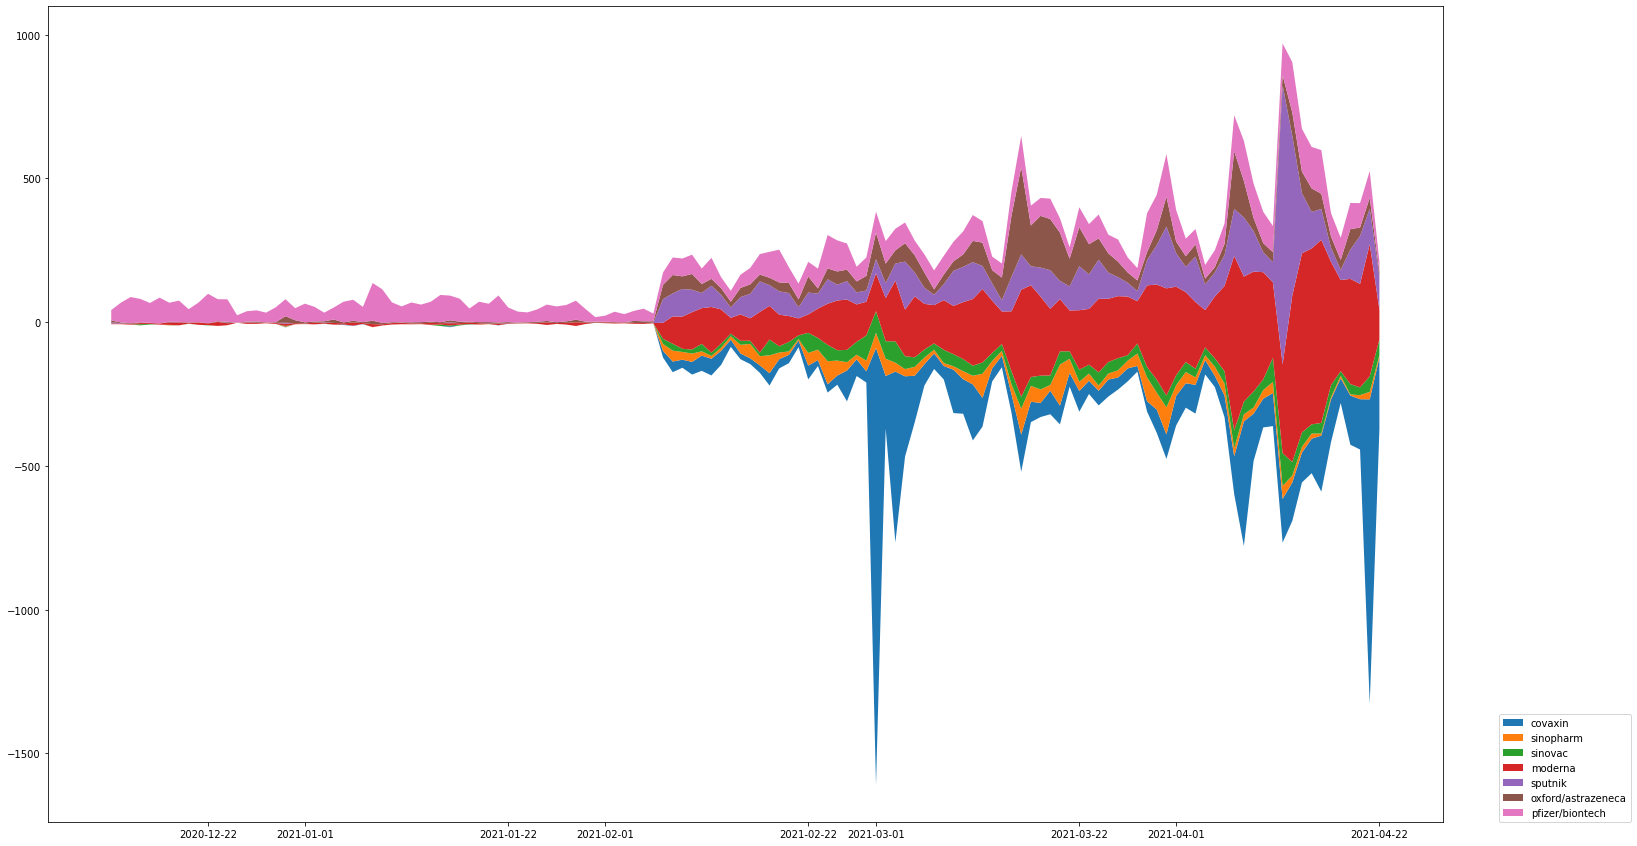

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(river.index, river.T, baseline='wiggle', labels=river.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

## Sankey Diagram

In [ ]:
#['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['oxford/astrazeneca']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='oxford/astrazeneca'
oxford_astrazeneca=vaccine
oxford_astrazeneca=oxford_astrazeneca.rename({'oxford/astrazeneca': 'quantity'}, axis=1)
oxford_astrazeneca

Analysis  quantity             Vaccine
0  Negative      1855  oxford/astrazeneca
1  Positive      3132  oxford/astrazeneca

In [ ]:
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['pfizer/biontech']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='pfizer/biontech'
pfizer_biontech=vaccine
pfizer_biontech=pfizer_biontech.rename({'pfizer/biontech': 'quantity'}, axis=1)
pfizer_biontech

Analysis  quantity          Vaccine
0  Negative      3217  pfizer/biontech
1  Positive      6118  pfizer/biontech

In [ ]:
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['covaxin']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='covaxin'
covaxin=vaccine
covaxin=covaxin.rename({'covaxin': 'quantity'}, axis=1)
covaxin

Analysis  quantity  Vaccine
0  Negative      3117  covaxin
1  Positive      6337  covaxin

In [ ]:
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['sinopharm']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='sinopharm'
sinopharm=vaccine
sinopharm=sinopharm.rename({'sinopharm': 'quantity'}, axis=1)
sinopharm

Analysis  quantity    Vaccine
0  Negative       752  sinopharm
1  Positive      1756  sinopharm

In [ ]:
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['sinovac']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='sinovac'
sinovac=vaccine
sinovac=sinovac.rename({'sinovac': 'quantity'}, axis=1)
sinovac

Analysis  quantity  Vaccine
0  Negative      1024  sinovac
1  Positive      1900  sinovac

In [ ]:
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['moderna']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='moderna'
moderna=vaccine
moderna=moderna.rename({'moderna': 'quantity'}, axis=1)
moderna

Analysis  quantity  Vaccine
0  Negative      6190  moderna
1  Positive     11482  moderna

In [ ]:
#river_data["covaxin"]=river_data["covaxin"].astype(int)
vaccine = river_data.groupby(by=["Analysis"]).sum()['sputnik']
vaccine= vaccine.reset_index()
vaccine["Vaccine"]='sputnik'
sputnik=vaccine
sputnik=sputnik.rename({'sputnik': 'quantity'}, axis=1)
sputnik

Analysis  quantity  Vaccine
0  Negative      3049  sputnik
1  Positive      5204  sputnik

In [ ]:
Sankeyss=oxford_astrazeneca.append(pfizer_biontech, ignore_index=True)
Sankeyss=Sankeyss.append(covaxin, ignore_index=True)
Sankeyss=Sankeyss.append(sinopharm, ignore_index=True)
Sankeyss=Sankeyss.append(sinovac, ignore_index=True)
Sankeyss=Sankeyss.append(moderna, ignore_index=True)
Sankeyss=Sankeyss.append(sputnik, ignore_index=True)
Sankeyss

Analysis  quantity             Vaccine
0   Negative      1855  oxford/astrazeneca
1   Positive      3132  oxford/astrazeneca
2   Negative      3217     pfizer/biontech
3   Positive      6118     pfizer/biontech
4   Negative      3117             covaxin
5   Positive      6337             covaxin
6   Negative       752           sinopharm
7   Positive      1756           sinopharm
8   Negative      1024             sinovac
9   Positive      1900             sinovac
10  Negative      6190             moderna
11  Positive     11482             moderna
12  Negative      3049             sputnik
13  Positive      5204             sputnik

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
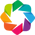

In [ ]:
import holoviews as hv
import plotly.graph_objects as go
import plotly.express as pex
hv.extension('bokeh')

In [ ]:
all_nodes = Sankeyss.Vaccine.values.tolist() + Sankeyss.Analysis.values.tolist()
source_indices = [all_nodes.index(Vaccine) for Vaccine in Sankeyss.Vaccine]
target_indices = [all_nodes.index(Analysis) for Analysis in Sankeyss.Analysis]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

node_colors_mappings = dict([(node,np.random.choice(colors)) for node in all_nodes])
node_colors = [node_colors_mappings[node] for node in all_nodes]
edge_colors = [node_colors_mappings[node] for node in Sankeyss.Vaccine]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "black", width = 1.0),
      label =  all_nodes,
      color =  node_colors,
    ),

    link = dict(
      source =  source_indices,
      target =  target_indices,
      value =  Sankeyss.quantity,
      color = edge_colors,
))])

fig.update_layout(title_text="Sankey Diagram representation between Vaccines and Sentiments",
                  height=600,
                  font_size=10)
fig.show()

# Most common Word

In [ ]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(10)) for tag in cfd.conditions())


def vax_word(df):
    fr=df['processed_tweets']
    fr=fr.astype(str)
    sentences = fr.str.cat(sep = ' ')
    sentences = sentences.lower()
    sentences = '"' + sentences + '"'
    text =  nltk.tokenize.word_tokenize(sentences)
    sentences = nltk.pos_tag(text)
    for i in ('NN', 'VB'):
        tagdict = findtags(i, sentences)
        print(tagdict)

In [ ]:
nltk.download('averaged_perceptron_tagger')
def filtered_timeline(df, vax):
    df = df.dropna()
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    return df_filt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
vac=filtered_timeline(df3, ['oxford', 'astrazeneca'])
vax_word(vac)

{'NN': [('vaccine', 721), ('jab', 178), ('today', 140), ('country', 118), ('blood', 79), ('clot', 73), ('vaccination', 64), ('effect', 64), ('use', 61), ('day', 60)], 'NNS': [('people', 81), ('thanks', 38), ('ford', 20), ('data', 13), ('thats', 8), ('jab', 6), ('yes', 6), ('whats', 5), ('dos', 5), ('politics', 5)], 'NNP': [('\u200d', 4), ('…', 3), ('macron', 2), ('dont', 1), ('£100m', 1), ('yemi', 1), ('وأولُرعة…', 1), ('xxxxxxx', 1), ('£384', 1), ('zombie', 1)]}
{'VBG': [('embarrassing', 59), ('getting', 39), ('feeling', 33), ('going', 18), ('using', 17), ('taking', 13), ('giving', 10), ('amazing', 8), ('making', 8), ('including', 8)], 'VBZ': [('says…', 15), ('jab', 9), ('seems', 7), ('approves', 5), ('say…', 5), ('suspends', 4), ('astrazeneca', 4), ('continues', 4), ('netherlands', 4), ('suggests', 3)], 'VBD': [('got', 96), ('suspended', 63), ('received', 41), ('said', 23), ('went', 14), ('vaccinated', 13), ('put', 13), ('thank', 12), ('rejected', 12), ('died', 11)], 'VBN': [('done',

In [ ]:
import nltk
import json
import tkinter as tk
from nltk.tokenize import word_tokenize
from tkinter import filedialog


sample_text = vac["processed_tweets"].str.cat(sep = ' ')


def create_json(word_freq):
	pos_dict = {
			"CC":1,"CD": 2,"DT": 3,"EX": 4,"FW": 5, "IN": 6, 
			"JJ": 7, "JJR": 8,"JJS": 9,"LS": 10, "MD": 11,
			"NN": 12, "NNS": 13, "NNP": 14, "NNPS": 15, "PDT": 16,
			"POS": 17,"PRP": 18,"PRP$": 19, "RB": 20,"RBR": 21,
			"RBS": 22,"RP": 23,"TO": 24,"UH": 25, "VB": 26,
			"VBD": 27, "VBG": 28, "VBN": 29, "VBP": 30, "VBZ": 31,
			"WDT": 32, "WP": 33, "WP$": 34, "WRD": 35
		}
	data = {}
	nodes = []
	links = []			
	
	for word, freq in word_freq.items():
		if nltk.tag.pos_tag([word])[0][1] in pos_dict:
			group = pos_dict[nltk.tag.pos_tag([word])[0][1]]
		else:
			group = 99

		nodes.append({"id": word, "group": group, "label": word, "level": 2})
		links.append( {"source": word, "target": nltk.tag.pos_tag([word])[0][1], "strength": freq})

	nodes.append({"id": "partsOfSpeech", "group": 100, "label": "Parts Of Speech", "level": 3})	
	for tag,val in pos_dict.items():
		nodes.append({"id": tag, "group": val, "label": tag, "level": 1})
		links.append({"source": tag, "target": "partsOfSpeech", "strength": 1})

	data['nodes'] = nodes
	data['links'] = links

	with open('data.json', 'w') as outfile:
		json.dump(data, outfile)
		
tokenized = word_tokenize(sample_text)
word_frequency_dist = nltk.FreqDist(tokenized)


word_freq = dict((tokenized, freq) for tokenized, freq in word_frequency_dist.items())
create_json(word_freq)

In [ ]:
word_freq

{'celebrity': 1,
 'cook': 1,
 'presenter': 2,
 'getting': 44,
 'new': 32,
 'vaccine': 950,
 'west': 2,
 'oxfordshire': 2,
 'today…': 3,
 'comment': 5,
 '12222020': 1,
 'astrazeneca': 120,
 'chec…': 1,
 'apart': 8,
 'great': 30,
 'news': 50,
 'oxford': 76,
 'astra': 11,
 'zeneca': 11,
 'approved': 19,
 'also': 24,
 'update': 14,
 'al…': 4,
 'earth': 2,
 'rollout': 20,
 'not': 148,
 'starting': 5,
 'next': 17,
 'week': 65,
 'ive': 31,
 'friend': 12,
 'former': 1,
 'nurse': 5,
 '1…': 1,
 'uk': 78,
 'approval': 9,
 'huge': 11,
 'development': 5,
 'nationally': 2,
 'internationall…': 1,
 'oxfordastrazeneca': 34,
 'covid': 90,
 '19': 8,
 'public': 10,
 'use': 90,
 'awaiting': 3,
 'in…': 11,
 'stored': 1,
 'standard': 2,
 'fridge': 1,
 'u…': 4,
 'plan': 9,
 'changed': 4,
 'following': 7,
 'start': 8,
 'fiddling': 1,
 'timeline': 2,
 '2nd': 31,
 'dose…': 2,
 'experimented': 1,
 'administered': 10,
 'first': 265,
 'people': 93,
 'today': 161,
 'second': 53,
 'vacci…': 8,
 'sir': 3,
 'john': 4,
